# **SENTIMENT ANALYSIS OF CODE-MIXED TAMIL ENGLISH AND PURE TAMIL YOUTUBE COMMENTS WITH SENTIMENT-BASED SUMMARIZATION**


---



## ***1. Importing Libraries***

In [ ]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, pairwise_distances
from scipy.spatial.distance import cosine
from transformers import BertTokenizer, TFBertForSequenceClassification, AutoModelForTokenClassification, AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
from googleapiclient.discovery import build

Imports all the necessary libraries for the project, including:
- NLP tools (Transformers, Sklearn)
- TensorFlow models
- Data processing (Pandas, NumPy, Regex)
- Gradio for interface
- YouTube API and video data extractors


## ***2. Loading Datasets***

In [ ]:
# code- mixed tamil dataset
train_file_path = "/content/tamil_train - tamil_train.csv"
df_train = pd.read_csv(train_file_path)

test_file_path = "/content/tamil_test - tamil_test.csv"
df_test = pd.read_csv(test_file_path)

# Pure tamil dataset
pure_tamil_train = pd.read_csv('/content/pure_tamil_train.csv')
pure_tamil_test = pd.read_csv('/content/pure_tamil_test.csv')

## ***3. Preprocessing***

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)     # remove mentions
    text = re.sub(r"#\w+", "", text)     # remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove digits
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # reduce repeated characters
    text = re.sub(r'\s+', ' ', text).strip()    # remove extra spaces
    return text

df_train['cleaned_text'] = df_train['text'].apply(preprocess_text)
df_test['cleaned_text'] = df_test['text'].apply(preprocess_text)
X_test = df_test['cleaned_text']



In [ ]:
def preprocess_tamil_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\u0B80-\u0BFF\s]', '', text)  # Retain only Tamil characters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

pure_tamil_train['cleaned_text_t'] = pure_tamil_train['text'].apply(preprocess_tamil_text)
pure_tamil_test['cleaned_text_t'] = pure_tamil_test['text'].apply(preprocess_tamil_text)

X = pure_tamil_train['cleaned_text_t']
y = pure_tamil_train['label']
X_testt = pure_tamil_test['cleaned_text_t']

In [ ]:
label_to_id = {label: idx for idx, label in enumerate(y.unique())}
id_to_label = {idx: label for label, idx in label_to_id.items()}
y_encoded = y.map(label_to_id)

In this step, we preprocess the data that is, cleaning up the raw YouTube comments so the models can understand them better.
text = re.sub(r'[^\u0B80-\u0BFF\s]', '', text)-  it keeps only Tamil characters and removes everything else (like emojis, English words, numbers). \u0B80-\u0BFF is the Unicode range for Tamil script.

Label mapping converts sentiment labels (like "positive", "negative") into numbers, which machine learning models can understand. Labels are converted  into numbers using a label-to-ID mapping. After prediction, the results are converted back into text using the reverse mapping. This step ensures our models and results stay interpretable

## ***4. Train Test Split***

In [ ]:
X = df_train['cleaned_text']
y = df_train['category']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
y_encoded = y_encoded[:len(X)]
X_traint, X_valt, y_traint, y_valt = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [ ]:
print("Shape of X:", X.shape)
print("Shape of y_encoded:", y_encoded.shape)
print("Number of missing values in 'label' column:", pure_tamil_train['label'].isnull().sum())


Shape of X: (18000,)
Shape of y_encoded: (18000,)
Number of missing values in 'label' column: 0


Splits both code-mixed and pure Tamil datasets into training and validation sets.
- `train_test_split()` is used to split with stratification to maintain label balance.
- Separate splits are created for IndicBERT (pure Tamil) and BERT (code-mixed).



## ***5. TF- IDF Vectorization***

In [ ]:
# TF- IDF Vectorization
from sklearn.pipeline import FeatureUnion
char_vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5), max_features=5000)
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), max_features=5000)
hybrid_vectorizer = FeatureUnion([("char", char_vectorizer), ("word", word_vectorizer)])

# Fit and transform using X_train
X_train_tfidf = hybrid_vectorizer.fit_transform(X_train)

# Transform X_val and df_test
X_val_tfidf = hybrid_vectorizer.transform(X_val)
X_test_tfidf = hybrid_vectorizer.transform(df_test['cleaned_text'])


In [ ]:
# TF-IDF (char + word)
from sklearn.pipeline import FeatureUnion
char_vectorizer_t= TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5), max_features=5000)
word_vectorizer_t= TfidfVectorizer(analyzer='word', ngram_range=(1, 2), max_features=5000)
hybrid_vectorizer_t = FeatureUnion([("char", char_vectorizer_t), ("word", word_vectorizer_t)])

X_train_tfidf_t = hybrid_vectorizer_t.fit_transform(X_traint)
X_val_tfidf_t = hybrid_vectorizer_t.transform(X_valt)
X_test_tfidf_t = hybrid_vectorizer_t.transform(X_testt)


Applies TF-IDF vectorization using:
- Character n-grams (3 to 5)
- Word n-grams (1 to 2)

Combines character-level patterns (like groups of 3–5 characters) with word-level patterns (single words and word pairs). This hybrid approach helps the model catch both spelling variations and meaning. The result is a feature matrix that can be used for training and testing the sentiment classifiers


## ***6. Train Baseline Models***

> ***6.1 Logistic Regression and Random Forest***



In [ ]:
lr = LogisticRegression()
rf = RandomForestClassifier()

In [ ]:
lr.fit(X_train_tfidf, y_train)
rf.fit(X_train_tfidf, y_train)

# Predictions on Training and Test Data
y_train_preds_lr = lr.predict(X_train_tfidf) # Generate predictions for training data using Logistic Regression
y_train_preds_rf = rf.predict(X_train_tfidf) # Generate predictions for training data using Random Forest
lr_preds = lr.predict(X_test_tfidf)
rf_preds = rf.predict(X_test_tfidf)


df_test['Logistic_Regression_Prediction'] = lr_preds
df_test['Random_Forest_Prediction'] = rf_preds

df_test.to_csv("tamil_test_labeled.csv", index=False)
print("Labeled test data saved as tamil_test_labeled.csv")
print("--------------------------------------------------")
print("Logistic Regression Accuracy:")
print(classification_report(y_train, y_train_preds_lr))
print("Random Forest Accuracy:")
print(classification_report(y_train, y_train_preds_rf))

Labeled test data saved as tamil_test_labeled.csv
--------------------------------------------------
Logistic Regression Accuracy:
                precision    recall  f1-score   support

Mixed_feelings       0.89      0.25      0.39      1026
      Negative       0.83      0.44      0.58      1159
      Positive       0.77      0.99      0.87      6102
     not-Tamil       0.84      0.63      0.72       294
 unknown_state       0.80      0.22      0.34       487

      accuracy                           0.78      9068
     macro avg       0.83      0.51      0.58      9068
  weighted avg       0.80      0.78      0.74      9068

Random Forest Accuracy:
                precision    recall  f1-score   support

Mixed_feelings       1.00      0.99      1.00      1026
      Negative       1.00      1.00      1.00      1159
      Positive       1.00      1.00      1.00      6102
     not-Tamil       0.98      1.00      0.99       294
 unknown_state       1.00      1.00      1.00       487



In [ ]:
lr.fit(X_train_tfidf_t, y_traint)
rf.fit(X_train_tfidf_t, y_traint)

# Predict and evaluate
y_val_preds_lr = lr.predict(X_val_tfidf_t)
y_val_preds_rf = rf.predict(X_val_tfidf_t)
print("Logistic Regression Report:")
print(classification_report(y_valt, y_val_preds_lr))
print("Random Forest Report:")
print(classification_report(y_valt, y_val_preds_rf))

# Predict on test data
pure_tamil_test['LR_Prediction'] = lr.predict(X_test_tfidf_t)
pure_tamil_test['RF_Prediction'] = rf.predict(X_test_tfidf_t)

# Save predictions
pure_tamil_test.to_csv("pure_tamil_test_labeled.csv", index=False)
print("Saved predictions to pure_tamil_test_labeled.csv")


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1940
           1       0.87      0.81      0.84      1660

    accuracy                           0.86      3600
   macro avg       0.86      0.85      0.86      3600
weighted avg       0.86      0.86      0.86      3600

Random Forest Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1940
           1       0.88      0.81      0.84      1660

    accuracy                           0.86      3600
   macro avg       0.86      0.86      0.86      3600
weighted avg       0.86      0.86      0.86      3600

Saved predictions to pure_tamil_test_labeled.csv


## ***7. BERT Model***

> ***7.1 Loading BERT***



In [ ]:
# BERT Model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=5)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Load IndicBERT model and tokenizer
model_name = "ai4bharat/indic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
indic_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_to_id), from_pt=True) # Add from_pt=True

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertForSequenceClassification: ['sop_classifier.classifier.bias', 'sop_classifier.classifier.weight']
- This IS expected if you are initializing TFAlbertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This part Loads:
- BERT multilingual model (`bert-base-multilingual-cased`) for code-mixed sentiment classification.
- IndicBERT (`ai4bharat/indic-bert`) for pure Tamil classification.
Both models are initialized with the correct number of output labels.




> ***7.2 Tokenization***



In [ ]:
# Tokenization
def tokenize_bert(texts):
    return bert_tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors="tf")

tokenized_train = tokenize_bert(X_train)
tokenized_test = tokenize_bert(X_test)

y_train_encoded = pd.factorize(y_train)[0]


In [ ]:
# Tokenization
def tokenize_indicbert(texts):
    return tokenizer(list(texts), padding=True, truncation=True, return_tensors="tf")

tokenized_indictrain = tokenize_indicbert(X_traint)
tokenized_indicval = tokenize_indicbert(X_valt)
tokenized_indictest = tokenize_indicbert(X_testt)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Tokenizes the text data using the BERT tokenizer with truncation and padding.
- `tokenize_bert()` prepares data for training and testing using `bert-base-multilingual-cased`.

Tokenizes text using IndicBERT tokenizer.
- `tokenize_indicbert()` is applied to pure Tamil training, validation, and test data. Tokenized inputs are fed into the IndicBERT model.




> ***7.3 Training BERT***



In [ ]:
# Training BERT
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
bert_model.fit(tokenized_train['input_ids'], np.array(y_train_encoded), epochs=5, batch_size=20)

Epoch 1/5
454/454 [==============================] - 157s 250ms/step - loss: 1.0370 - accuracy: 0.6715
Epoch 2/5
454/454 [==============================] - 115s 254ms/step - loss: 0.9330 - accuracy: 0.6852
Epoch 3/5
454/454 [==============================] - 116s 256ms/step - loss: 0.8546 - accuracy: 0.7024
Epoch 4/5
454/454 [==============================] - 117s 257ms/step - loss: 0.7613 - accuracy: 0.7332
Epoch 5/5
454/454 [==============================] - 117s 257ms/step - loss: 0.6439 - accuracy: 0.7748


In [ ]:
# Compile and train
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_traint), y=y_traint)
class_weights = {i: w for i, w in enumerate(class_weights)}

indic_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

indic_model.fit(
    [tokenized_indictrain['input_ids'], tokenized_indictrain['attention_mask']],
    np.array(y_traint),
    epochs=3,
    batch_size=20,
    validation_data=(
        [tokenized_indicval['input_ids'], tokenized_indicval['attention_mask']],
        np.array(y_valt)
    )
)



Epoch 1/3
720/720 [==============================] - 1080s 1s/step - loss: 0.5659 - accuracy: 0.7138 - val_loss: 0.4750 - val_accuracy: 0.7897
Epoch 2/3
720/720 [==============================] - 1123s 2s/step - loss: 0.4278 - accuracy: 0.8094 - val_loss: 0.4268 - val_accuracy: 0.8017
Epoch 3/3
720/720 [==============================] - 1118s 2s/step - loss: 0.3584 - accuracy: 0.8427 - val_loss: 0.3957 - val_accuracy: 0.8158


In [ ]:
# Save trained model
bert_model.save_pretrained("saved_bert_model")
bert_tokenizer.save_pretrained("saved_bert_model")

('saved_bert_model/tokenizer_config.json',
 'saved_bert_model/special_tokens_map.json',
 'saved_bert_model/vocab.txt',
 'saved_bert_model/added_tokens.json')

In [ ]:
indic_model.save_pretrained("saved_indicbert_model")
tokenizer.save_pretrained("saved_indicbert_model")

('saved_indicbert_model/tokenizer_config.json',
 'saved_indicbert_model/special_tokens_map.json',
 'saved_indicbert_model/spiece.model',
 'saved_indicbert_model/added_tokens.json',
 'saved_indicbert_model/tokenizer.json')

Compiles and trains the BERT model using:
- Adam optimizer
- Sparse Categorical Crossentropy loss (since labels are integer encoded)
-
Trains the model for 5 epochs on tokenized data.

Finally the model is saved for future use




> ***7.4 Predictions using BERT***



In [ ]:
# Predictions using BERT
tokenized_test = tokenize_bert(X_test)
predictions = bert_model.predict(tokenized_test['input_ids'])[0]
predicted_labels = np.argmax(predictions, axis=1)
df_test['BERT_Prediction'] = predicted_labels

df_test.to_csv("tamil_test_labeled.csv", index=False)
print("Updated labeled test data saved as tamil_test_labeled.csv")


99/99 [==============================] - 15s 122ms/step
Updated labeled test data saved as tamil_test_labeled.csv


In [ ]:
tokenized_indictest = tokenize_indicbert(X_testt)

# Predict on test data
test_preds = indic_model.predict(tokenized_indictest['input_ids'])[0]
test_pred_labels = np.argmax(test_preds, axis=1)

pure_tamil_test.to_csv("Pure_tamil_test_labeled.csv", index=False)
print("Labeled test data saved as Pure_tamil_test_labeled.csv")


188/188 [==============================] - 149s 775ms/step
Labeled test data saved as Pure_tamil_test_labeled.csv


Makes predictions on the test data using the trained BERT model.
- Tokenizes the test set
- Gets prediction logits
- Converts logits to class indices using `argmax`
- Saves predictions into a CSV file




> ***7.5 Evaluation***



In [ ]:
# Evaluate BERT Model on Training Data
print("BERT Model Performance (on Training Data):")
train_predictions = bert_model.predict(tokenized_train['input_ids'])[0]
y_train_preds_bert = np.argmax(train_predictions, axis=1)
print(classification_report(y_train_encoded, y_train_preds_bert))
print("BERT Accuracy:", accuracy_score(y_train_encoded, y_train_preds_bert))

BERT Model Performance (on Training Data):
284/284 [==============================] - 38s 125ms/step
              precision    recall  f1-score   support

           0       0.87      0.99      0.92      6102
           1       0.71      0.21      0.33      1026
           2       0.78      0.72      0.75      1159
           3       0.91      0.96      0.94       294
           4       0.83      0.72      0.77       487

    accuracy                           0.85      9068
   macro avg       0.82      0.72      0.74      9068
weighted avg       0.84      0.85      0.83      9068

BERT Accuracy: 0.8520070577856198


In [ ]:
# Evaluate
val_preds = indic_model.predict({
    'input_ids': tokenized_indicval['input_ids'],
    'attention_mask': tokenized_indicval['attention_mask']
})[0]

val_pred_labels = np.argmax(val_preds, axis=1)
print("IndicBERT Classification Report:")
print(classification_report(np.array(y_valt), val_pred_labels))

113/113 [==============================] - 96s 827ms/step
IndicBERT Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1940
           1       0.77      0.86      0.81      1660

    accuracy                           0.82      3600
   macro avg       0.82      0.82      0.82      3600
weighted avg       0.82      0.82      0.82      3600



Evaluates the trained BERT model on the code-mixed training set.
- Generates predicted labels
- Prints classification report and accuracy score


## ***8. Youtube Analysis***

*   ***Sentiment Analysis for code-mixed Tamil***
*   ***Sentiment Analysis for Pure Tamil***

*   ***Youtube comment Summarization***

*   ***Meta Data Extraction***










> ***8.0 Installing and Importing Libraries***



In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=a688eeb90e7ffdf85022048075c0783b6626242e8110713cd25c3d311371a2ed
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
!pip install pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install yt_dlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 84.8 MB/s eta 0:00:00


In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c1f945430a271580652ff14381d0638b9ae5d645bfa5b62e79a3e2c2e853dedb
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import re
import os
import numpy as np
import pandas as pd
from langdetect import detect
from transformers import (
    TFBertForSequenceClassification, BertTokenizer,
    AutoTokenizer, TFAutoModelForSequenceClassification,
    pipeline
)
import tensorflow as tf
import gradio as gr
from googleapiclient.discovery import build
import yt_dlp
import sacrebleu
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import bert_score


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer




> ***8.1 Load Models***



In [ ]:
code_mixed_model = TFBertForSequenceClassification.from_pretrained("saved_bert_model")
code_mixed_tokenizer = BertTokenizer.from_pretrained("saved_bert_model")

indicbert_model = TFAutoModelForSequenceClassification.from_pretrained("saved_indicbert_model")
indicbert_tokenizer = AutoTokenizer.from_pretrained("saved_indicbert_model")

summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=-1)


Some layers from the model checkpoint at saved_bert_model were not used when initializing TFBertForSequenceClassification: ['dropout_42']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at saved_bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
Some layers from the model checkpoint at saved_indicbert_model were not used 

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


This section loads the pretrained models:
- `code_mixed_model`: A BERT model fine-tuned on code-mixed Tamil-English data.
- `indicbert_model`: IndicBERT fine-tuned for sentiment classification on pure Tamil data.
Both models are used dynamically based on the detected language of the input comment.

Additionally BART model is loaded for sentiment based summarization

In [ ]:
#Label MApping
label_map = {
    0: 'Neutral',
    1: 'Positive',
    2: 'Negative',
    3: 'Mixed-Feelings',
    4: 'Neutral'
}
class_labels = list(label_map.values())

Defines a label map to convert model output indices into human-readable sentiment labels: Positive, Negative, and Neutral.




> ***8.2Youtube Setup***



In [2]:
from google.colab import userdata
youtube_api_key = userdata.get('YOUTUBE_API_KEY')

In [ ]:


def extract_video_id(url):
    if 'youtu.be' in url:
        return url.split('/')[-1].split('?')[0]
    elif 'youtube.com' in url:
        return re.search(r'[?&]v=([^&]+)', url).group(1)
    else:
        raise ValueError('Invalid YouTube URL')

def initialize_youtube():
    global youtube
    youtube = build('youtube', 'v3', developerKey=youtube_api_key)

def get_youtube_comments(video_url, max_results=100):
    initialize_youtube()
    try:
        video_id = extract_video_id(video_url)
        comments = []

        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=max_results
        ).execute()

        for item in response.get('items', []):
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(preprocess_text(comment))

        return comments
    except Exception as e:
        print("Error fetching comments:", str(e))
        return []

Initializes the YouTube API and includes a helper function to extract video IDs from different YouTube URL formats.
Used to fetch comments from the provided video link.




> ***8.3 Preprocessing***



In [ ]:
# Text Cleaning & Language Detection
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r'[^\w\s\u0B80-\u0BFF]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def unicode_is_tamil(text):
    tamil_chars = [char for char in text if '\u0B80' <= char <= '\u0BFF']
    return len(tamil_chars) / max(1, len(text)) > 0.75

def is_pure_tamil(text):
    try:
        lang = detect(text)
        if lang == 'ta':
            return True
    except:
        pass
    return unicode_is_tamil(text)


Cleans each comment by removing URLs, symbols, and noise.  
Then detects if a comment is pure Tamil using Unicode character checks and the `langdetect` library.  
This helps decide whether to use BERT or IndicBERT.




> ***8.4 Sentiment Prediction***



In [ ]:
def predict_comment_sentiment(comment):
    if is_pure_tamil(comment):
        tokenizer = indicbert_tokenizer
        model = indicbert_model
    else:
        tokenizer = code_mixed_tokenizer
        model = code_mixed_model

    encodings = tokenizer([comment], truncation=True, padding=True, return_tensors='tf')
    preds = model.predict(encodings['input_ids'])[0]
    label = class_labels[np.argmax(preds)]
    return label

def predict_sentiment_dual(comments):
    predictions = []
    for comment in comments:
        label = predict_comment_sentiment(comment)
        predictions.append((comment, label))
    return pd.DataFrame(predictions, columns=["Comment", "Sentiment"])


This section tokenizes each comment and sends it to the appropriate model:
- IndicBERT for pure Tamil comments
- Multilingual BERT for code-mixed comments
Predicted labels are mapped to sentiment classes using the label map.

Processes all the comments in a batch and returns a DataFrame with the original comment and the predicted sentiment.  
This result is later used for CSV export and summarization.




> ***8.5 Summarization and Meta Data Extraction***



In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def chunk_and_summarize(comments, label, chunk_size=3000):
    if not comments:
        return f"No {label} comments to summarize."
    cleaned = [clean_text(c) for c in comments[:50] if isinstance(c, str)]
    full_text = " ".join(cleaned)[:chunk_size]
    summary = summarizer(full_text, max_length=100, min_length=30, do_sample=False)[0]['summary_text']
    return summary

def compute_rouge(reference, summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, summary)
    return {
        "ROUGE-1": scores['rouge1'].fmeasure,
        "ROUGE-L": scores['rougeL'].fmeasure
    }


def compute_bleu_alternative(reference, summary):
    vectorizer = CountVectorizer().fit([reference, summary])
    vectors = vectorizer.transform([reference, summary])
    cosine_sim = cosine_similarity(vectors[0], vectors[1])
    return {"BLEU-Alt (Cosine Sim)": float(cosine_sim[0][0])}


def get_video_metadata(url):
    try:
        with yt_dlp.YoutubeDL({}) as ydl:
            info = ydl.extract_info(url, download=False)
            return {
                "Title": info.get("title"),
                "Channel": info.get("uploader"),
                "Views": info.get("view_count"),
                "Publish Date": info.get("upload_date"),
                "Video Length (sec)": info.get("duration")
            }
    except Exception as e:
        return {"Error": f"Could not fetch metadata: {str(e)}"}


Summarizes the top comments for each sentiment class (Positive, Negative, Neutral) using the BART summarization model.
Also fetches video metadata like title, views, and channel name using `yt_dlp`.




> ***8.6 Gradio Integration***



In [ ]:
def analyze_youtube_sentiment(video_url):
    try:
        comments = get_youtube_comments(video_url)
        if not comments:
            return "No comments found or error.", "", None

        df = predict_sentiment_dual(comments)
        df.dropna(subset=['Comment'], inplace=True)

        # Save CSV
        output_path = "youtube_sentiment_results_dual.csv"
        df.to_csv(output_path, index=False)

        # Summarize
        pos = df[df['Sentiment'] == 'Positive']['Comment'].tolist()
        neg = df[df['Sentiment'] == 'Negative']['Comment'].tolist()
        neu = df[df['Sentiment'] == 'Neutral']['Comment'].tolist()


        pos_summary = chunk_and_summarize(pos, "Positive")
        neg_summary = chunk_and_summarize(neg, "Negative")
        neu_summary = chunk_and_summarize(neu, "Neutral")

        # Evaluation
        pos_text = " ".join(pos)
        neg_text = " ".join(neg)
        neu_text = " ".join(neu)

        scores = {}
        for label, ref, summ in [
            ("Positive", pos_text, pos_summary),
            ("Negative", neg_text, neg_summary),
            ("Neutral", neu_text, neu_summary)
        ]:
            rouge = compute_rouge(ref, summ)

            bleu = compute_bleu_alternative(ref, summ)

            scores[label] = {**rouge, **bleu}

        evaluation_str = "\n\n".join(
            f"**{label} Scores**:\n" + "\n".join(f"{k}: {v:.4f}" for k, v in metric.items())
            for label, metric in scores.items()
        )

        # Metadata
        metadata = get_video_metadata(video_url)
        metadata_str = "\n".join(f"{k}: {v}" for k, v in metadata.items())

        # Summaries formatted
        summaries = f"""**Positive Summary**: {pos_summary}
**Negative Summary**: {neg_summary}
**Neutral Summary**: {neu_summary}

🔍 **Evaluation Metrics**:
{evaluation_str}
"""


        return metadata_str, summaries, output_path

    except Exception as e:
        return f"Error: {str(e)}", "", None

# Gradio Interface

iface = gr.Interface(
    fn=analyze_youtube_sentiment,
    inputs=gr.Textbox(label="📺 Enter YouTube URL"),
    outputs=[
        gr.Textbox(label="🎬 Video Metadata"),
        gr.Textbox(label="📝 Sentiment Summaries"),
        gr.File(label="📁 Download CSV with Sentiments")
    ],
    title="🎭 YouTube Sentiment Analyzer - Code-Mixed & Pure Tamil",
    description="Auto-detects language in comments and uses BERT or IndicBERT for sentiment classification. Also summarizes and extracts metadata."
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a2f5f6fc52c9f0d1fd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


The core function that runs the entire sentiment analysis pipeline:
1. Scrapes comments from the YouTube video
2. Performs sentiment analysis using the dual-model approach
3. Summarizes each sentiment category
4. Retrieves and formats video metadata
5. Saves the results to a CSV
Returns all of the above for display.

Builds the Gradio web app interface:
- Takes a YouTube URL as input
- Displays metadata, summaries, and downloadable CSV as output
- Allows sharing or running as a live app


##  ***9. Data Visualization***

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import seaborn as sns



> ***9.1 Confusion Matrix for BERT***



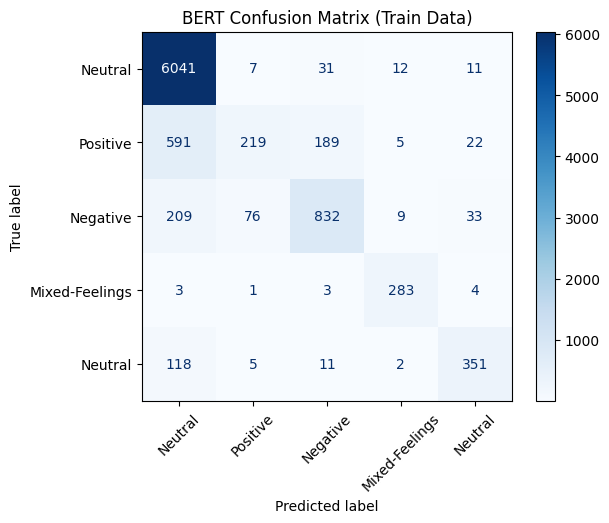

In [ ]:

cm = confusion_matrix(y_train_encoded, y_train_preds_bert)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.values())
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("BERT Confusion Matrix (Train Data)")
plt.show()




> ***9.2 Confusion Matrix for IndicBERT***



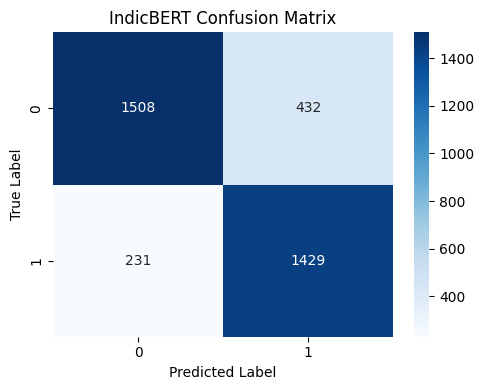

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(np.array(y_valt), val_pred_labels)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(label_to_id.keys()), yticklabels=sorted(label_to_id.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("IndicBERT Confusion Matrix")
plt.tight_layout()
plt.show()





> ***9.3 Model accuracy Comparison for Code-mixed Tamil***



<ipython-input-51-b011d115424d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Logistic Regression', 'Random Forest', 'BERT'],


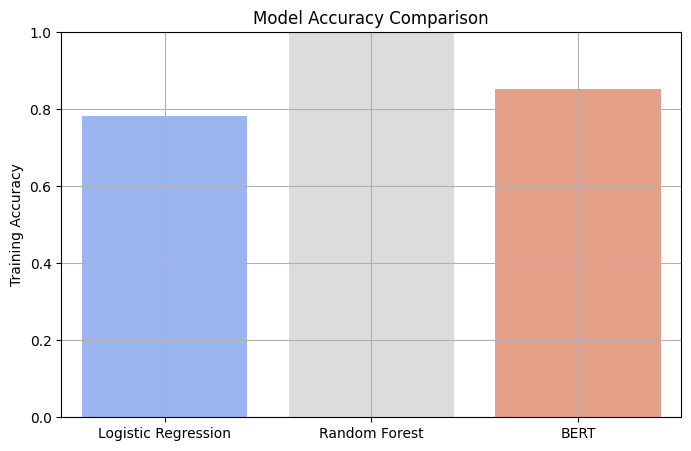

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy scores
bert_acc = accuracy_score(y_train_encoded, y_train_preds_bert)
lr_acc = accuracy_score(y_train, y_train_preds_lr)
rf_acc = accuracy_score(y_train, y_train_preds_rf)


# Accuracy comparison bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=['Logistic Regression', 'Random Forest', 'BERT'],
            y=[lr_acc, rf_acc, bert_acc],
            palette='coolwarm')
plt.ylabel("Training Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.grid(True)
plt.show()




> ***9.4 Model Accuracy Comparison for Pure Tamil***



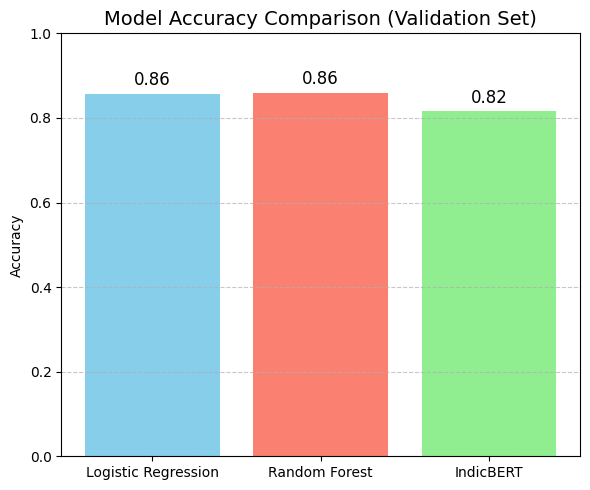

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Accuracy values (adjust these based on your real output if needed)
lr_acc = accuracy_score(y_valt, y_val_preds_lr)
rf_acc = accuracy_score(y_valt, y_val_preds_rf)
indicbert_acc = accuracy_score(np.array(y_valt), val_pred_labels)

# Bar chart
plt.figure(figsize=(6, 5))
models = ['Logistic Regression', 'Random Forest', 'IndicBERT']
accuracies = [lr_acc, rf_acc, indicbert_acc]

plt.bar(models, accuracies, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Model Accuracy Comparison (Validation Set)', fontsize=14)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
